In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-financial-news/valid_data.csv
/kaggle/input/twitter-financial-news/train_data.csv


In [27]:
# ============================================
# ALL IMPORTS - RUN THIS FIRST
# ============================================

# Standard library
import os
import re
from datetime import datetime, timedelta

# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Deep Learning
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from tqdm.auto import tqdm

# API calls
import requests

# Metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Other
from collections import Counter
from wordcloud import WordCloud

print("✅ All imports loaded successfully!")

✅ All imports loaded successfully!


In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv('/kaggle/input/twitter-financial-news/train_data.csv')
val_df =pd.read_csv('/kaggle/input/twitter-financial-news/valid_data.csv')
# Check what we actually have
print("Unique labels:", df['label'].unique())
print("Label data type:", df['label'].dtype)
print("\nFirst few rows:")
print(df[['text', 'label']].head())

# CORRECT mapping - using NUMERIC keys (0, 1, 2...) not "LABEL_0"
label_mapping = {
    0: "Analyst Update",
    1: "Fed | Central Banks",
    2: "Company | Product News",
    3: "Treasuries | Corporate Debt",
    4: "Dividend",
    5: "Earnings",
    6: "Energy | Oil",
    7: "Financials",
    8: "Currencies",
    9: "General News | Opinion",
    10: "Gold | Metals | Materials",
    11: "IPO",
    12: "Legal | Regulation",
    13: "M&A | Investments",
    14: "Macro",
    15: "Markets",
    16: "Politics",
    17: "Personnel Change",
    18: "Stock Commentary",
    19: "Stock Movement"
}

# NOW this should work
df['topic_name'] = df['label'].map(label_mapping)
val_df['topic_name']=val_df['label'].map(label_mapping)

# Verify
print("\nAfter mapping:")
print(df[['text', 'label', 'topic_name']].head())
print("\nAny NaN values?", df['topic_name'].isna().sum())
print("\nTopic distribution:")
print(df['topic_name'].value_counts())
print(val_df[['text', 'label', 'topic_name']].head())
print("\nTopic distribution:")
print(val_df['topic_name'].value_counts())

Unique labels: [ 0  2  9  8  4  5  6  1  7 10 11 12 13 14 15 17 16 18 19  3]
Label data type: int64

First few rows:
                                                text  label
0  Here are Thursday's biggest analyst calls: App...      0
1  Buy Las Vegas Sands as travel to Singapore bui...      0
2  Piper Sandler downgrades DocuSign to sell, cit...      0
3  Analysts react to Tesla's latest earnings, bre...      0
4  Netflix and its peers are set for a ‘return to...      0

After mapping:
                                                text  label      topic_name
0  Here are Thursday's biggest analyst calls: App...      0  Analyst Update
1  Buy Las Vegas Sands as travel to Singapore bui...      0  Analyst Update
2  Piper Sandler downgrades DocuSign to sell, cit...      0  Analyst Update
3  Analysts react to Tesla's latest earnings, bre...      0  Analyst Update
4  Netflix and its peers are set for a ‘return to...      0  Analyst Update

Any NaN values? 0

Topic distribution:
topic_name


In [3]:
# Run this first to see EXACTLY what you have
print("Column names:")
print(df.columns.tolist())
print("\n" + "="*50 + "\n")

print("Dataset shape:", df.shape)
print("\n" + "="*50 + "\n")

print("First 3 rows:")
print(df.head(3))
print("\n" + "="*50 + "\n")

print("Data types:")
print(df.dtypes)
print("\n" + "="*50 + "\n")

print("Label column info:")
print(df['label'].describe())
print("\nUnique labels:", sorted(df['label'].unique()))

Column names:
['text', 'label', 'topic_name']


Dataset shape: (16990, 3)


First 3 rows:
                                                text  label      topic_name
0  Here are Thursday's biggest analyst calls: App...      0  Analyst Update
1  Buy Las Vegas Sands as travel to Singapore bui...      0  Analyst Update
2  Piper Sandler downgrades DocuSign to sell, cit...      0  Analyst Update


Data types:
text          object
label          int64
topic_name    object
dtype: object


Label column info:
count    16990.000000
mean         9.547616
std          6.401000
min          0.000000
25%          2.000000
50%          9.000000
75%         16.000000
max         19.000000
Name: label, dtype: float64

Unique labels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)]


/tmp/ipykernel_55/331231798.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')


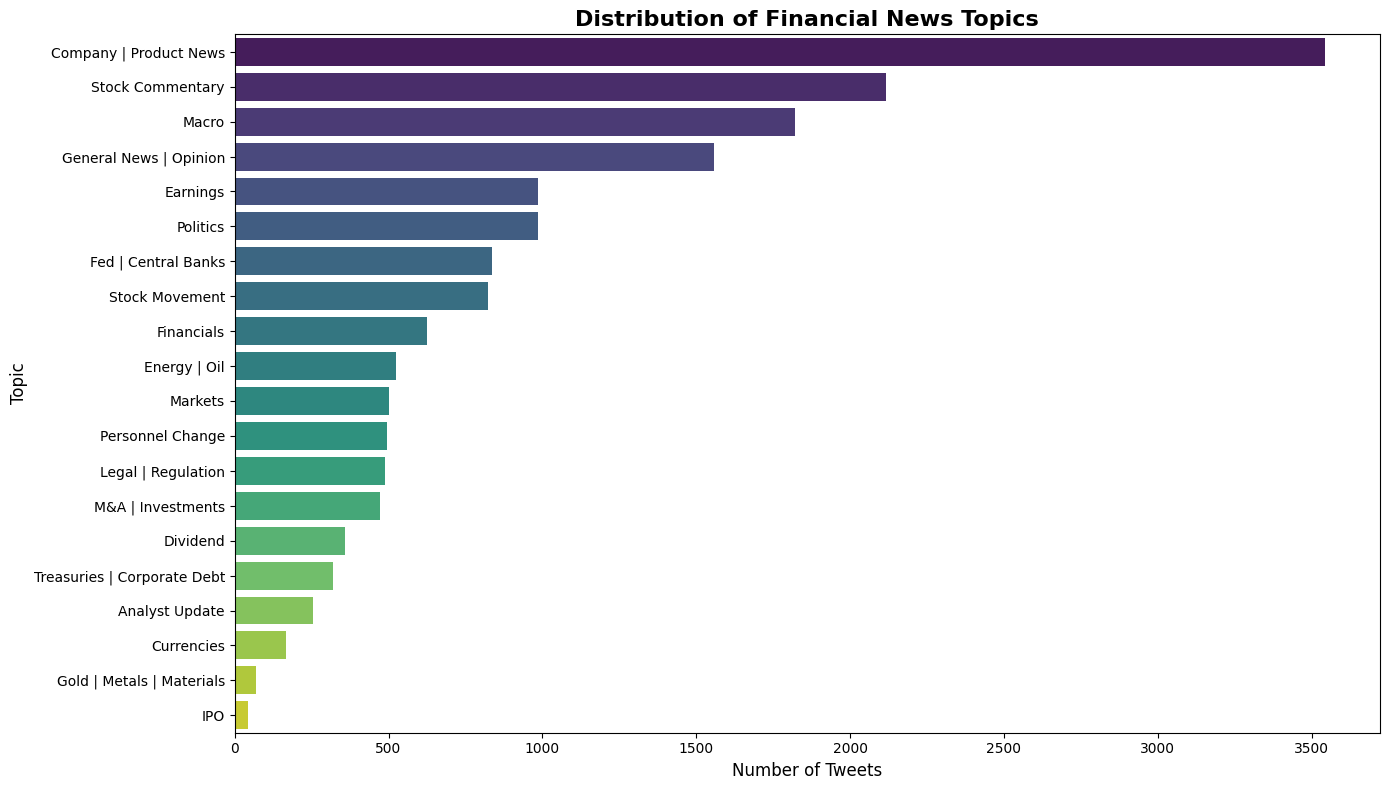


✅ Visualization saved as 'topic_distribution.png'

SUMMARY STATISTICS
Total tweets: 16,990
Number of topics: 20
Most common topic: Company | Product News (3,545 tweets)
Least common topic: IPO (44 tweets)
Class imbalance ratio: 80.57x


In [4]:
# ============================================
# STEP 1: IMPORT LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# STEP 6: BASIC VISUALIZATION
# ============================================
# Topic distribution
plt.figure(figsize=(14, 8))
topic_counts = df['topic_name'].value_counts()
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')
plt.title('Distribution of Financial News Topics', fontsize=16, fontweight='bold')
plt.xlabel('Number of Tweets', fontsize=12)
plt.ylabel('Topic', fontsize=12)
plt.tight_layout()
plt.savefig('topic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved as 'topic_distribution.png'")

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Total tweets: {len(df):,}")
print(f"Number of topics: {df['topic_name'].nunique()}")
print(f"Most common topic: {topic_counts.index[0]} ({topic_counts.values[0]:,} tweets)")
print(f"Least common topic: {topic_counts.index[-1]} ({topic_counts.values[-1]:,} tweets)")
print(f"Class imbalance ratio: {topic_counts.values[0] / topic_counts.values[-1]:.2f}x")

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16990 entries, 0 to 16989
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16990 non-null  object
 1   label       16990 non-null  int64 
 2   topic_name  16990 non-null  object
dtypes: int64(1), object(2)
memory usage: 398.3+ KB


In [6]:
import re
import nltk
import pandas as pd
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

class FinancialTextPreprocessor:
    """
    Preprocessor specifically designed for financial tweets
    
    WHY: Financial text has special characteristics:
    - Stock tickers ($AAPL, $TSLA) are important signals
    - Numbers and percentages carry meaning ("+5%", "$100M")
    - Financial jargon (IPO, M&A, Fed, GDP)
    - URLs often link to news sources
    """
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        # Don't remove financial indicators
        keep_words = {'up', 'down', 'above', 'below', 'more', 'less', 'high', 'low'}
        self.stop_words = self.stop_words - keep_words
        self.lemmatizer = WordNetLemmatizer()
    
    def extract_tickers(self, text):
        """Extract stock ticker symbols ($AAPL, $TSLA)"""
        if pd.isna(text):
            return []
        return re.findall(r'\$[A-Z]{1,5}\b', str(text))
    
    def extract_hashtags(self, text):
        """Extract hashtags"""
        if pd.isna(text):
            return []
        return re.findall(r'#\w+', str(text))
    
    def extract_mentions(self, text):
        """Extract user mentions"""
        if pd.isna(text):
            return []
        return re.findall(r'@\w+', str(text))
    
    def extract_numbers(self, text):
        """Extract percentages and numbers"""
        if pd.isna(text):
            return {'percentages': [], 'money': []}
        text = str(text)
        percentages = re.findall(r'-?\d+\.?\d*%', text)
        money = re.findall(r'\$\d+\.?\d*[BMK]?', text)
        return {'percentages': percentages, 'money': money}
    
    def clean_text(self, text):
        """
        Clean text while preserving financial context
        
        Steps:
        1. Lowercase (for uniformity)
        2. Remove URLs (not useful for topic classification)
        3. Remove mentions (focus on content)
        4. Remove special chars (keep alphanumeric)
        5. Tokenize
        6. Remove stopwords
        7. Lemmatize (reduce words to base form)
        """
        # Handle NaN or empty text
        if pd.isna(text) or text == '':
            return ''
        
        # Convert to string (just in case)
        text = str(text)
        
        # Lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+', '', text)
        
        # Remove mentions (but we saved them earlier)
        text = re.sub(r'@\w+', '', text)
        
        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        # If text is empty after cleaning, return empty string
        if not text.strip():
            return ''
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and short tokens
        tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if token not in self.stop_words and len(token) > 2
        ]
        
        return ' '.join(tokens)
    
    def process_dataframe(self, df, text_column='text'):
        """
        Process entire dataframe
        
        Creates new columns:
        - clean_text: Cleaned version of text
        - tickers: List of stock tickers mentioned
        - hashtags: List of hashtags
        - word_count: Number of words
        - char_count: Number of characters
        """
        print("🔄 Extracting features from tweets...")
        
        # Extract features BEFORE cleaning (they'll be removed during cleaning)
        df['tickers'] = df[text_column].apply(self.extract_tickers)
        df['hashtags'] = df[text_column].apply(self.extract_hashtags)
        df['mentions'] = df[text_column].apply(self.extract_mentions)
        df['numbers'] = df[text_column].apply(self.extract_numbers)
        
        print("🧹 Cleaning text...")
        df['clean_text'] = df[text_column].apply(self.clean_text)
        
        print("📊 Calculating statistics...")
        # Add text statistics - FIXED VERSION
        df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()) if x else 0)
        df['char_count'] = df['clean_text'].apply(lambda x: len(x) if x else 0)
        df['ticker_count'] = df['tickers'].apply(len)
        df['hashtag_count'] = df['hashtags'].apply(len)
        
        print("✅ Preprocessing complete!")
        return df

# Apply preprocessing
print("Starting preprocessing...")
preprocessor = FinancialTextPreprocessor()
df = preprocessor.process_dataframe(df)
val_df = preprocessor.process_dataframe(val_df)

# Create directory if it doesn't exist
output_dir = '/kaggle/working/data/processed'
os.makedirs(output_dir, exist_ok=True)

# Save processed data
file_path = os.path.join(output_dir, 'tweets_with_features.csv')
df.to_csv(file_path, index=False)
print(f"✅ File saved successfully to: {file_path}")

# Print summary
print("\n📊 Preprocessing Summary:")
print(f"Total tweets processed: {len(df):,}")
print(f"Average words per tweet: {df['word_count'].mean():.1f}")
print(f"Tweets with tickers: {(df['ticker_count'] > 0).sum():,}")
print(f"Tweets with hashtags: {(df['hashtag_count'] > 0).sum():,}")

# Show sample
print("\n📝 Sample of processed data:")
print(df[['text', 'clean_text', 'word_count', 'ticker_count']].head())
print(val_df[['text', 'clean_text', 'word_count', 'ticker_count']].head())


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Starting preprocessing...
🔄 Extracting features from tweets...
🧹 Cleaning text...
📊 Calculating statistics...
✅ Preprocessing complete!
🔄 Extracting features from tweets...
🧹 Cleaning text...
📊 Calculating statistics...
✅ Preprocessing complete!
✅ File saved successfully to: /kaggle/working/data/processed/tweets_with_features.csv

📊 Preprocessing Summary:
Total tweets processed: 16,990
Average words per tweet: 11.8
Tweets with tickers: 5,445
Tweets with hashtags: 1,705

📝 Sample of processed data:
                                                text  \
0  Here are Thursday's biggest analyst calls: App...   
1  Buy Las Vegas Sands as travel to Singapore bui...   
2  Piper Sandler downgrades DocuSign to sell, cit...   
3  Analysts react to Tesla's latest earnings, bre...   
4  Netflix and its peers are set for a ‘return to...   

                                          clean_text  word_count  ticker_count  
0  thursday biggest analyst call apple amazon tes...          12             0 

TOPIC DISTRIBUTION ANALYSIS

Total topics: 20
Total tweets: 16,990

Top 5 topics:
  1. Company | Product News: 3,545 tweets (20.9%)
  2. Stock Commentary: 2,118 tweets (12.5%)
  3. Macro: 1,822 tweets (10.7%)
  4. General News | Opinion: 1,557 tweets (9.2%)
  5. Earnings: 987 tweets (5.8%)

Bottom 5 topics:
  1. Treasuries | Corporate Debt: 321 tweets (1.9%)
  2. Analyst Update: 255 tweets (1.5%)
  3. Currencies: 166 tweets (1.0%)
  4. Gold | Metals | Materials: 69 tweets (0.4%)
  5. IPO: 44 tweets (0.3%)

⚠️ Class Imbalance Ratio: 80.6x


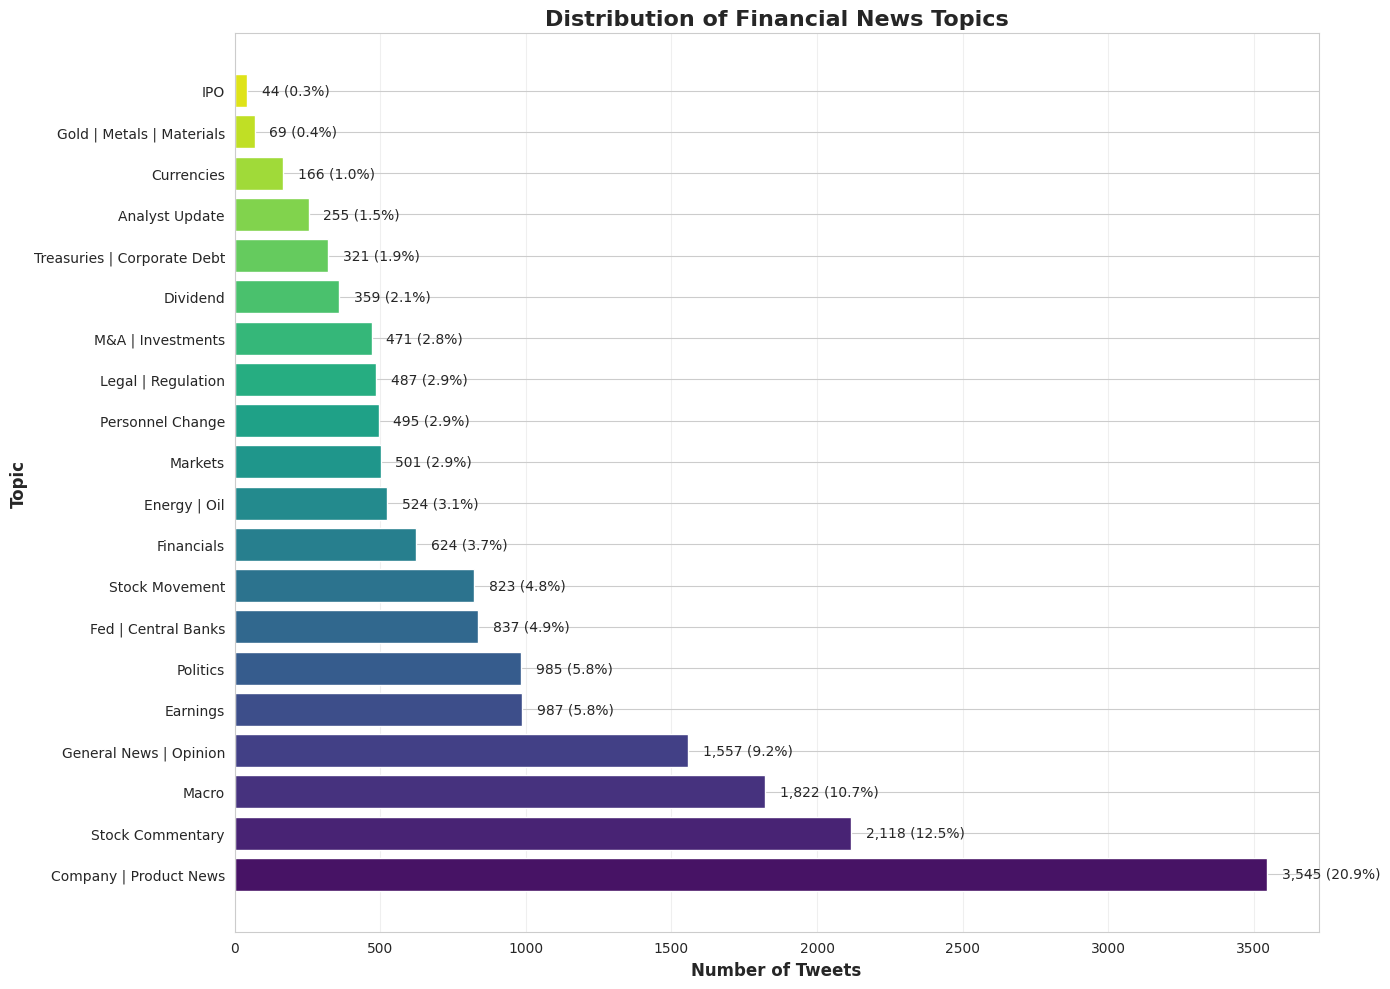


✅ Chart saved: topic_distribution.png


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)

print("="*60)
print("TOPIC DISTRIBUTION ANALYSIS")
print("="*60)

# Get topic counts
topic_counts = df['topic_name'].value_counts()

print(f"\nTotal topics: {df['topic_name'].nunique()}")
print(f"Total tweets: {len(df):,}\n")

print("Top 5 topics:")
for i, (topic, count) in enumerate(topic_counts.head(5).items(), 1):
    print(f"  {i}. {topic}: {count:,} tweets ({count/len(df)*100:.1f}%)")

print("\nBottom 5 topics:")
for i, (topic, count) in enumerate(topic_counts.tail(5).items(), 1):
    print(f"  {i}. {topic}: {count:,} tweets ({count/len(df)*100:.1f}%)")

# Class imbalance
max_count = topic_counts.max()
min_count = topic_counts.min()
imbalance_ratio = max_count / min_count

print(f"\n⚠️ Class Imbalance Ratio: {imbalance_ratio:.1f}x")

# Visualization
fig, ax = plt.subplots(figsize=(14, 10))
colors = sns.color_palette('viridis', len(topic_counts))
bars = ax.barh(topic_counts.index, topic_counts.values, color=colors)

for i, (bar, value) in enumerate(zip(bars, topic_counts.values)):
    ax.text(value + 50, i, f'{value:,} ({value/len(df)*100:.1f}%)', va='center')

ax.set_xlabel('Number of Tweets', fontsize=12, fontweight='bold')
ax.set_ylabel('Topic', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Financial News Topics', fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/topic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Chart saved: topic_distribution.png")

TEXT LENGTH ANALYSIS

Word Count Statistics:
  Mean: 11.8 words
  Median: 11.0 words
  Min: 0 words
  Max: 41 words
  Std: 5.3

Character Count Statistics:
  Mean: 81.4 characters
  Median: 75.0 characters

⚠️ Warning: 9 tweets became empty after cleaning


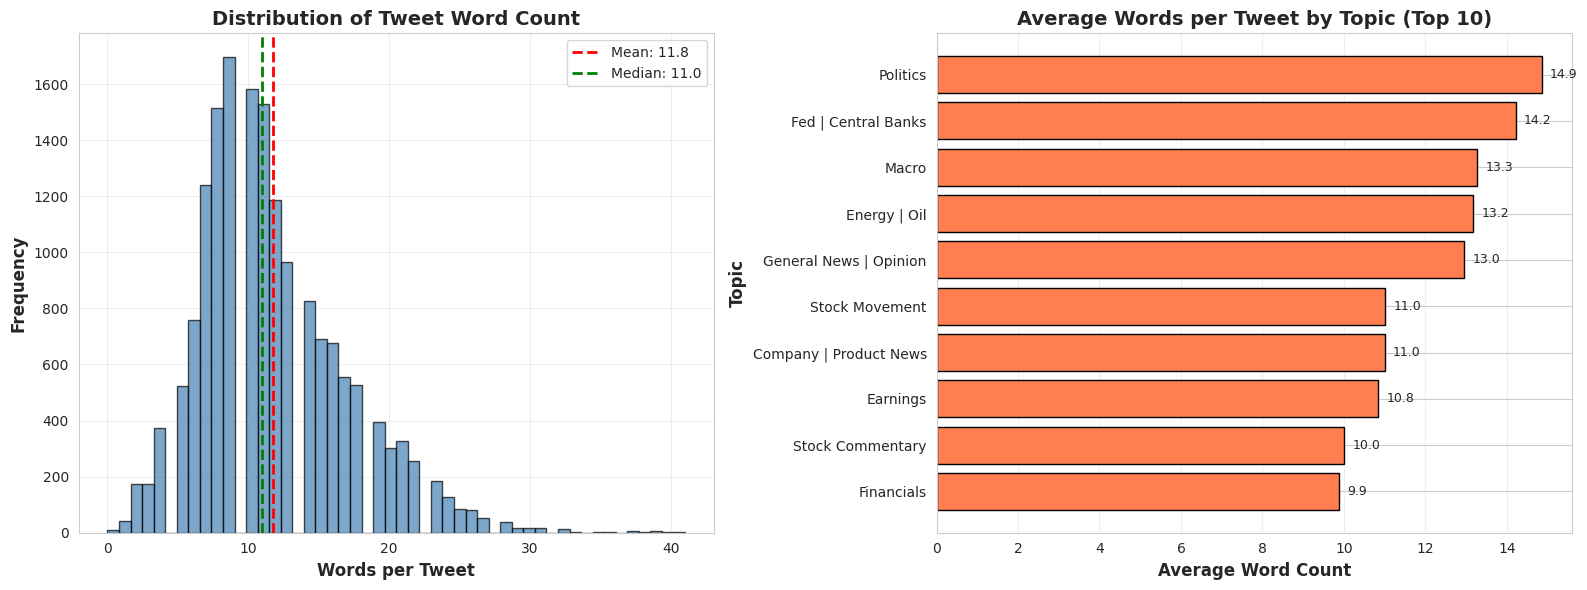


✅ Chart saved: word_count_analysis.png


In [8]:
print("="*60)
print("TEXT LENGTH ANALYSIS")
print("="*60)

# Overall statistics
print(f"\nWord Count Statistics:")
print(f"  Mean: {df['word_count'].mean():.1f} words")
print(f"  Median: {df['word_count'].median():.1f} words")
print(f"  Min: {df['word_count'].min()} words")
print(f"  Max: {df['word_count'].max()} words")
print(f"  Std: {df['word_count'].std():.1f}")

print(f"\nCharacter Count Statistics:")
print(f"  Mean: {df['char_count'].mean():.1f} characters")
print(f"  Median: {df['char_count'].median():.1f} characters")

# Empty tweets check
empty_tweets = (df['word_count'] == 0).sum()
if empty_tweets > 0:
    print(f"\n⚠️ Warning: {empty_tweets} tweets became empty after cleaning")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word count distribution
axes[0].hist(df['word_count'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['word_count'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {df["word_count"].mean():.1f}')
axes[0].axvline(df['word_count'].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Median: {df["word_count"].median():.1f}')
axes[0].set_xlabel('Words per Tweet', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Tweet Word Count', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Word count by topic (top 10 topics)
top_10_topics = topic_counts.head(10).index
topic_word_stats = df[df['topic_name'].isin(top_10_topics)].groupby('topic_name')['word_count'].mean().sort_values()

axes[1].barh(topic_word_stats.index, topic_word_stats.values, color='coral', edgecolor='black')
axes[1].set_xlabel('Average Word Count', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Topic', fontsize=12, fontweight='bold')
axes[1].set_title('Average Words per Tweet by Topic (Top 10)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(topic_word_stats.values):
    axes[1].text(v + 0.2, i, f'{v:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('/kaggle/working/word_count_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Chart saved: word_count_analysis.png")

STOCK TICKER ANALYSIS

Total unique tickers: 2,940
Total ticker mentions: 8,363
Tweets with tickers: 5,445 (32.0%)
Tweets without tickers: 11,545

🏆 Top 20 Most Mentioned Tickers:
   1. $SPY: 229 mentions
   2. $QQQ: 137 mentions
   3. $TSLA: 134 mentions
   4. $SPX: 118 mentions
   5. $AMZN: 86 mentions
   6. $TWTR: 78 mentions
   7. $WIRES: 75 mentions
   8. $NFLX: 72 mentions
   9. $DIA: 71 mentions
  10. $AAPL: 61 mentions
  11. $COMPQ: 51 mentions
  12. $DJIA: 50 mentions
  13. $BA: 49 mentions
  14. $SCANX: 43 mentions
  15. $NEPT: 42 mentions
  16. $SUMRX: 38 mentions
  17. $NVDA: 38 mentions
  18. $MSFT: 34 mentions
  19. $BAC: 32 mentions
  20. $GOOGL: 31 mentions


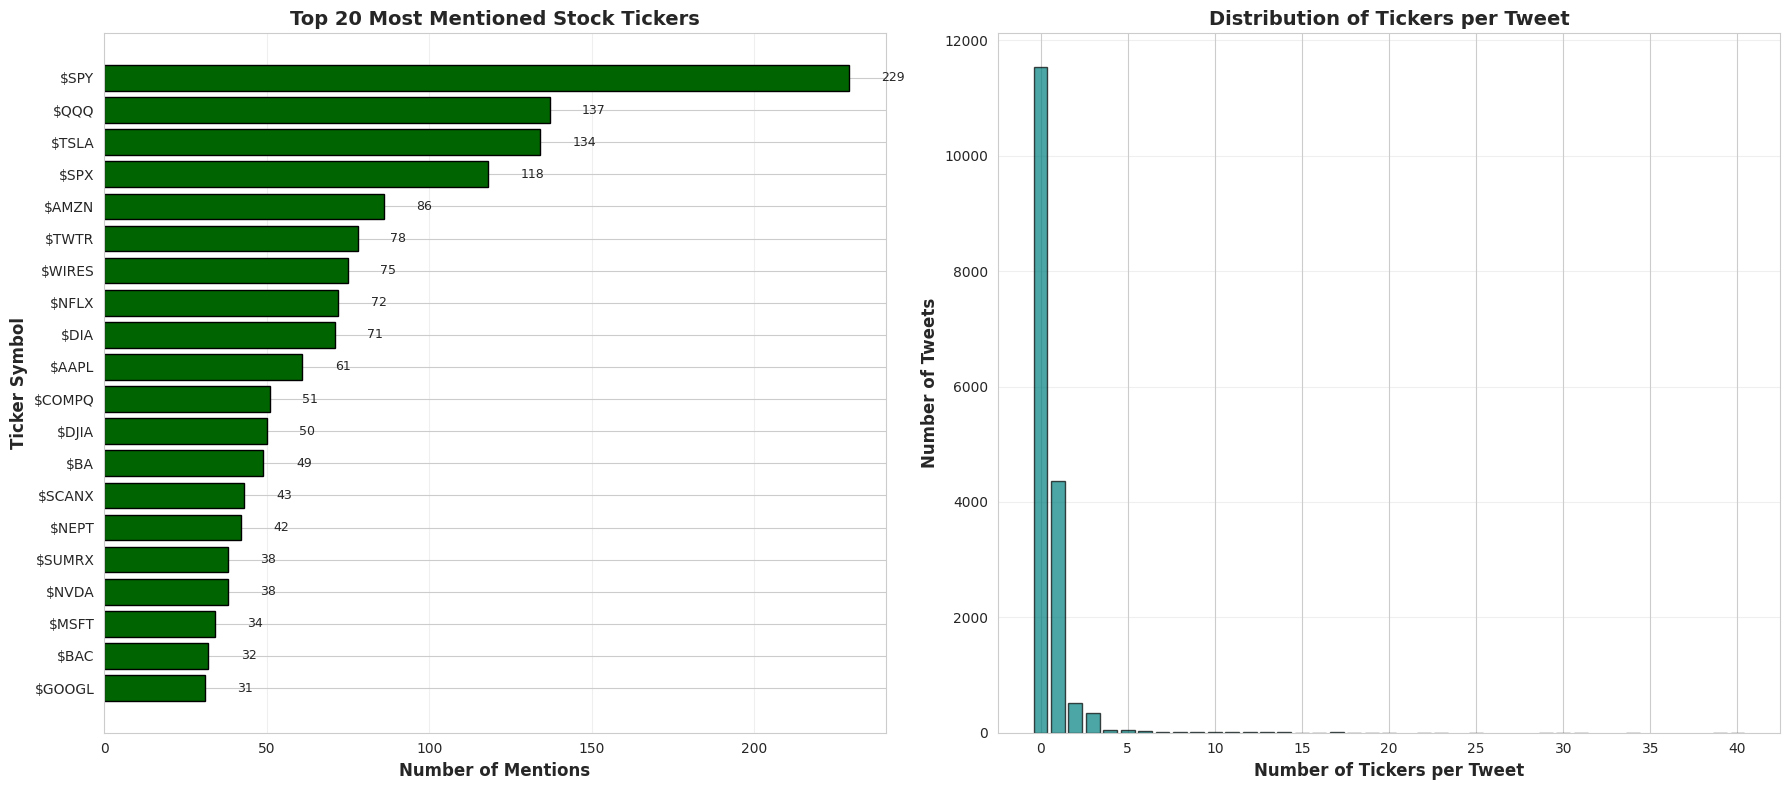


✅ Chart saved: ticker_analysis.png


In [9]:
from collections import Counter

print("="*60)
print("STOCK TICKER ANALYSIS")
print("="*60)

# Extract all tickers
all_tickers = [ticker for tickers in df['tickers'] for ticker in tickers]
ticker_counter = Counter(all_tickers)

print(f"\nTotal unique tickers: {len(ticker_counter):,}")
print(f"Total ticker mentions: {len(all_tickers):,}")
print(f"Tweets with tickers: {(df['ticker_count'] > 0).sum():,} ({(df['ticker_count'] > 0).sum()/len(df)*100:.1f}%)")
print(f"Tweets without tickers: {(df['ticker_count'] == 0).sum():,}")

# Top tickers
print("\n🏆 Top 20 Most Mentioned Tickers:")
top_tickers = pd.Series(ticker_counter).sort_values(ascending=False).head(20)
for i, (ticker, count) in enumerate(top_tickers.items(), 1):
    print(f"  {i:2d}. {ticker}: {count:,} mentions")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top 20 tickers
axes[0].barh(top_tickers.index[::-1], top_tickers.values[::-1], 
             color='darkgreen', edgecolor='black')
axes[0].set_xlabel('Number of Mentions', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Ticker Symbol', fontsize=12, fontweight='bold')
axes[0].set_title('Top 20 Most Mentioned Stock Tickers', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

for i, v in enumerate(top_tickers.values[::-1]):
    axes[0].text(v + 10, i, f'{v:,}', va='center', fontsize=9)

# Ticker count distribution
ticker_dist = df['ticker_count'].value_counts().sort_index()
axes[1].bar(ticker_dist.index, ticker_dist.values, color='teal', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Tickers per Tweet', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Tweets', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Tickers per Tweet', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/ticker_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Chart saved: ticker_analysis.png")

HASHTAG ANALYSIS

Total unique hashtags: 249
Total hashtag mentions: 4,879
Tweets with hashtags: 1,705 (10.0%)

🏆 Top 20 Most Used Hashtags:
   1. #stockmarket: 600 uses
   2. #economy: 591 uses
   3. #trading: 544 uses
   4. #stocks: 537 uses
   5. #finance: 536 uses
   6. #investing: 535 uses
   7. #markets: 526 uses
   8. #business: 524 uses
   9. #OOTT: 30 uses
  10. #earnings: 20 uses
  11. #inflation: 16 uses
  12. #Bitcoin: 11 uses
  13. #5things: 9 uses
  14. #NYSECommunity: 8 uses
  15. #5Things: 8 uses
  16. #FedData: 7 uses
  17. #financialmarkets: 7 uses
  18. #ThePoliticsSpace: 7 uses
  19. #totalreturnsectorindexfutures: 7 uses
  20. #bitcoin: 6 uses


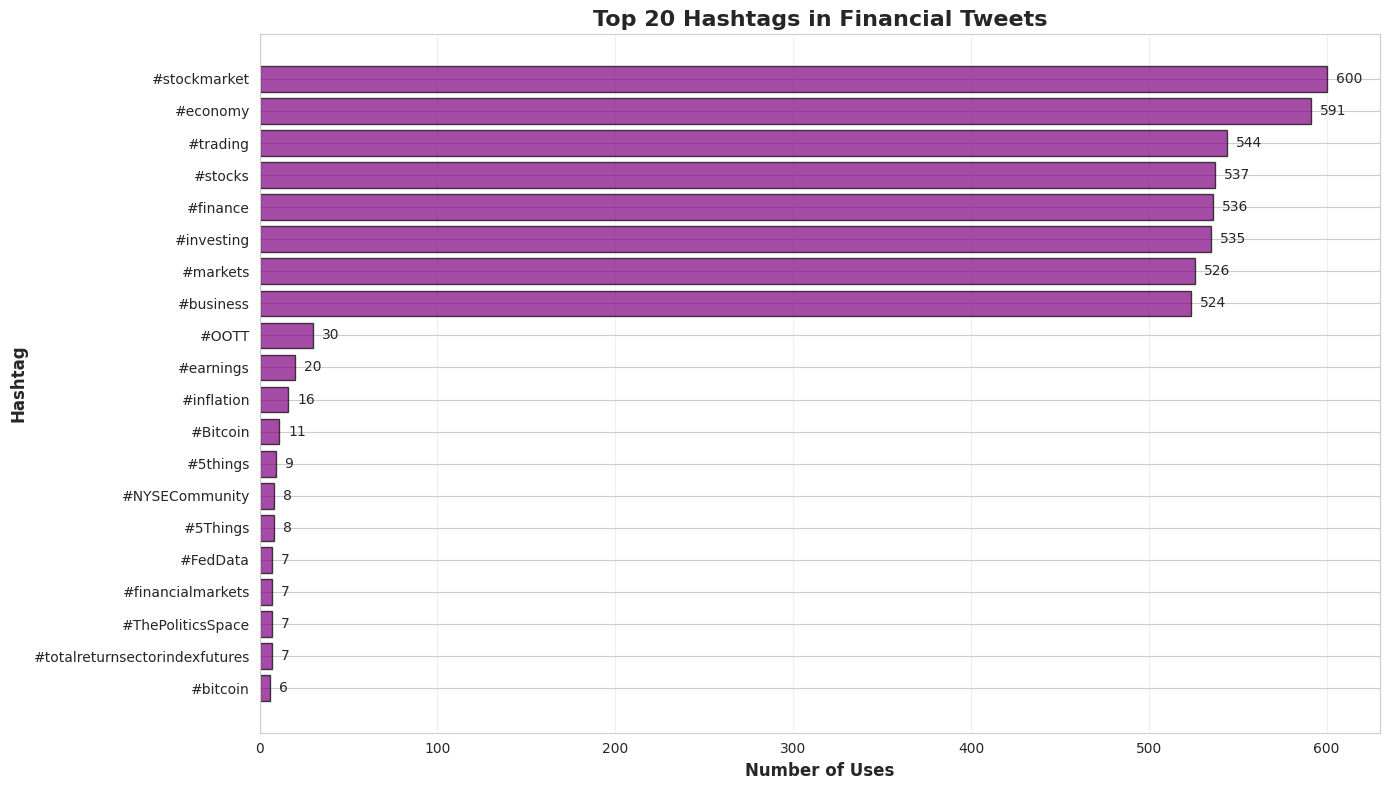


✅ Chart saved: hashtag_analysis.png


In [10]:
print("="*60)
print("HASHTAG ANALYSIS")
print("="*60)

# Extract all hashtags
all_hashtags = [tag for tags in df['hashtags'] for tag in tags]
hashtag_counter = Counter(all_hashtags)

print(f"\nTotal unique hashtags: {len(hashtag_counter):,}")
print(f"Total hashtag mentions: {len(all_hashtags):,}")
print(f"Tweets with hashtags: {(df['hashtag_count'] > 0).sum():,} ({(df['hashtag_count'] > 0).sum()/len(df)*100:.1f}%)")

# Top hashtags
print("\n🏆 Top 20 Most Used Hashtags:")
top_hashtags = pd.Series(hashtag_counter).sort_values(ascending=False).head(20)
for i, (tag, count) in enumerate(top_hashtags.items(), 1):
    print(f"  {i:2d}. {tag}: {count:,} uses")

# Visualization
plt.figure(figsize=(14, 8))
bars = plt.barh(top_hashtags.index[::-1], top_hashtags.values[::-1], 
                color='purple', edgecolor='black', alpha=0.7)

# Add value labels
for i, v in enumerate(top_hashtags.values[::-1]):
    plt.text(v + 5, i, f'{v:,}', va='center', fontsize=10)

plt.xlabel('Number of Uses', fontsize=12, fontweight='bold')
plt.ylabel('Hashtag', fontsize=12, fontweight='bold')
plt.title('Top 20 Hashtags in Financial Tweets', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('/kaggle/working/hashtag_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Chart saved: hashtag_analysis.png")

#FinBERT#

In [11]:
# CORRECT WAY to prepare dataset for fine-tuning
from datasets import Dataset
from transformers import AutoTokenizer
MODEL_NAME = "yiyanghkust/finbert-pretrain"

print(f"\n📥 Loading {MODEL_NAME}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_function(examples):
    """
    Tokenize text for FinBERT
    
    IMPORTANT: 
    - Must return 'input_ids' and 'attention_mask'
    - Labels must be integers 0-19
    - Max length 512 for FinBERT
    """
    return tokenizer(
        examples['text'],  # or 'clean_text' if you prefer
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors=None  # Don't convert to tensors yet
    )

# Create Hugging Face datasets
print("\n🔄 Creating Hugging Face datasets...")

# Select only needed columns
train_data = df[['text', 'label']].copy()  # or 'clean_text'
val_data = val_df[['text', 'label']].copy()

# Convert to Dataset format
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

# Tokenize datasets
print("\n🔄 Tokenizing datasets...")

train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text']  # Remove text, keep label
)

val_dataset = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text']
)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✅ Datasets ready!")

# VERIFY the dataset structure
print("\n📊 Dataset structure:")
print(f"Train features: {train_dataset.features}")
print(f"Sample: {train_dataset[0]}")


📥 Loading yiyanghkust/finbert-pretrain...


config.json:   0%|          | 0.00/359 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]


🔄 Creating Hugging Face datasets...
Train dataset: 16990 samples
Val dataset: 4117 samples

🔄 Tokenizing datasets...


Map:   0%|          | 0/16990 [00:00<?, ? examples/s]

Map:   0%|          | 0/4117 [00:00<?, ? examples/s]

✅ Datasets ready!

📊 Dataset structure:
Train features: {'label': Value('int64'), 'input_ids': List(Value('int32')), 'token_type_ids': List(Value('int8')), 'attention_mask': List(Value('int8'))}
Sample: {'label': tensor(0), 'input_ids': tensor([    3,  1094,    21, 18604,  5674,    58,  2952,   508,  2602,  3108,
         4145,   585,  6333,   585, 22679,   585, 18395,  9497,   437,   585,
        13392, 14045,  7809,   585, 16003,   152, 10988,  5036,    59,  9474,
        13035,    63,  3108,  1252,  1252,   599,    48,  3941,  1252,  3190,
          894,   445,   711, 24646,   604,   767,  2096,  1078,     4,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     

In [12]:
import torch
import pandas as pd
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    DataCollatorWithPadding
)
from datasets import Dataset
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


2026-01-14 00:10:44.576665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768349444.761357      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768349444.818942      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768349445.291166      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768349445.291256      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768349445.291259      55 computation_placer.cc:177] computation placer alr

Device: cuda


In [13]:
# CORRECT model initialization
from transformers import DataCollatorWithPadding

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True,
    return_tensors='pt'
)

print("✅ Data collator initialized")


# Initialize model with 20 classes
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=20,  # Your 20 topics
    ignore_mismatched_sizes=True  # IMPORTANT: Ignore pretrained head
)

# Move to GPU
model.to(device)

print(f"✅ Model loaded on {device}")
print(f"   Number of labels: {model.config.num_labels}")
print(f"   Model parameters: {model.num_parameters():,}")

✅ Data collator initialized


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded on cuda
   Number of labels: 20
   Model parameters: 109,767,188


In [14]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=512
    )

train_ds = Dataset.from_pandas(df)
val_ds   = Dataset.from_pandas(val_df)

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/16990 [00:00<?, ? examples/s]

Map:   0%|          | 0/4117 [00:00<?, ? examples/s]

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [16]:
# Training configuration (conservative settings to avoid errors)

training_args = TrainingArguments(
    output_dir="./finbert_finetuned",
    
    # Training settings
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Start small to avoid OOM
    per_device_eval_batch_size=16,
    
    # Learning rate
    learning_rate=2e-5,
    weight_decay=0.01,
    
    # Evaluation
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    
    # Logging
    logging_dir='./logs',
    logging_steps=100,
    report_to="none",  # Disable wandb if not needed
    
    # Memory optimization
    fp16=True,  # Use mixed precision (faster on T4)
    gradient_accumulation_steps=2,
    
    # Save space
    save_total_limit=2,
    
    # Important for debugging
    dataloader_num_workers=0,  # Avoid multiprocessing issues
)

print("✅ Training arguments configured")

✅ Training arguments configured


In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    """
    Compute accuracy, precision, recall, F1
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print("✅ Metrics function defined")

✅ Metrics function defined


In [18]:
# Initialize Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("✅ Trainer initialized")

# OPTIONAL: Test one batch before full training
print("\n🧪 Testing one batch...")
try:
    test_batch = next(iter(trainer.get_train_dataloader()))
    print(f"   Batch keys: {test_batch.keys()}")
    print(f"   Input shape: {test_batch['input_ids'].shape}")
    print(f"   Labels shape: {test_batch['labels'].shape}")
    print(f"   Labels min/max: {test_batch['labels'].min()}/{test_batch['labels'].max()}")
    
    # Try forward pass
    outputs = model(**test_batch.to(device))
    print(f"   Logits shape: {outputs.logits.shape}")
    print("   ✅ Forward pass successful!")
    
except Exception as e:
    print(f"   ❌ Error in test batch: {e}")

✅ Trainer initialized

🧪 Testing one batch...
   Batch keys: KeysView({'input_ids': tensor([[    3,  1971,  9249,  ...,     0,     0,     0],
        [    3, 30805,  5857,  ...,     0,     0,     0],
        [    3, 10132,  1181,  ...,     0,     0,     0],
        ...,
        [    3, 11845,    10,  ...,     0,     0,     0],
        [    3, 30805, 17482,  ...,     0,     0,     0],
        [    3,  1075,  8842,  ...,     0,     0,     0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), 'labels': tensor([ 9,  0,  0,  1,  2,  2, 14,  8,  2,  9, 14,  7, 13,  2, 13,  2],
       device='cuda:0')})
   Input shape: torch.Size([16, 512])
   Labels shape: torch.Size([16])
   Labels min/max: 0/14


/tmp/ipykernel_55/870957511.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


   Logits shape: torch.Size([16, 20])
   ✅ Forward pass successful!


In [19]:
# Train the model

print("\n" + "="*60)
print("🚀 STARTING FINE-TUNING")
print("="*60)

try:
    # Train
    train_result = trainer.train()
    
    print("\n✅ Training complete!")
    print(f"   Final loss: {train_result.training_loss:.4f}")
    
    # Evaluate
    print("\n📊 Evaluating on validation set...")
    eval_result = trainer.evaluate()
    
    print("\n📊 FINAL RESULTS:")
    for key, value in eval_result.items():
        print(f"   {key}: {value:.4f}")
    
    # Save model
    print("\n💾 Saving fine-tuned model...")
    trainer.save_model("./finbert_finetuned_final")
    tokenizer.save_pretrained("./finbert_finetuned_final")
    
    print("✅ Model saved to: ./finbert_finetuned_final")
    
except Exception as e:
    print(f"\n❌ ERROR during training:")
    print(f"   {type(e).__name__}: {e}")
    
    # Additional debugging info
    import traceback
    print("\n📋 Full traceback:")
    traceback.print_exc()


🚀 STARTING FINE-TUNING


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.568600,0.455200,0.864950,0.862316,0.864950,0.862070
2,0.294300,0.369589,0.889968,0.892692,0.889968,0.889896
3,0.153300,0.360852,0.894826,0.895865,0.894826,0.894725


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



✅ Training complete!
   Final loss: 0.4719

📊 Evaluating on validation set...


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 FINAL RESULTS:
   eval_loss: 0.3609
   eval_accuracy: 0.8948
   eval_precision: 0.8959
   eval_recall: 0.8948
   eval_f1: 0.8947
   eval_runtime: 78.5428
   eval_samples_per_second: 52.4170
   eval_steps_per_second: 1.6420
   epoch: 3.0000

💾 Saving fine-tuned model...
✅ Model saved to: ./finbert_finetuned_final


# DEEP learnin part


In [20]:
def analyze_with_llm(tweets_df, sentiment_type='negative'):
    # Prepare tweet text - limiting to 30 tweets to ensure we don't hit token limits
    tweets_text = "\n".join([
        f"{i+1}. {row['text'][:180]}" 
        for i, (_, row) in enumerate(tweets_df.head(30).iterrows())
    ])
    
    # SYSTEM PROMPT: Updated for Llama 3.3 strictness
    prompt = f"""You are a senior financial analyst. Analyze these {sentiment_type} tweets:
    {tweets_text}
    
    Provide:
    1. Top 3 Themes
    2. Main Companies Mentioned
    3. The primary reason for this sentiment
    
    Keep the total response under 150 words."""

    try:
        response = requests.post(
            "https://api.groq.com/openai/v1/chat/completions",
            headers={
                "Authorization": f"Bearer {GROQ_API_KEY}",
                "Content-Type": "application/json"
            },
            json={
                # CHANGED: Updated from 3.1-70b to 3.3-70b
                "model": "llama-3.3-70b-versatile", 
                "messages": [
                    {"role": "system", "content": "You are a concise financial expert."},
                    {"role": "user", "content": prompt}
                ],
                "temperature": 0.2, # Lower temperature for more stable analysis
                "max_tokens": 500
            },
            timeout=30
        )
        
        if response.status_code == 200:
            return response.json()['choices'][0]['message']['content']
        else:
            # This will help us see the REAL error message inside the 400
            error_details = response.json().get('error', {}).get('message', 'Unknown error')
            print(f"   ⚠️ API Error {response.status_code}: {error_details}")
            return f"LLM analysis failed: {error_details}"
            
    except Exception as e:
        print(f"   ⚠️ LLM Connection Error: {e}")
        return "LLM analysis unavailable"

In [22]:
# ============================================
# SENTIMENT ANALYSIS WITH FINBERT
# (This creates the 'finbert_score' column)
# ============================================

import torch
from transformers import pipeline
from tqdm.auto import tqdm

print("="*80)
print("SENTIMENT ANALYSIS - Creating finbert_score column")
print("="*80)

# Check GPU
device = 0 if torch.cuda.is_available() else -1
print(f"\nDevice: {'GPU' if device == 0 else 'CPU'}")

# Load FinBERT for SENTIMENT (not classification!)
print("\n📥 Loading FinBERT for sentiment analysis...")

finbert_sentiment = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",  # Pre-trained sentiment model
    device=device,
    batch_size=32,
    max_length=512,
    truncation=True
)

print("✅ FinBERT sentiment model loaded!")

def analyze_sentiment_batch(texts):
    """
    Analyze sentiment with FinBERT
    
    Returns: score (-1 to +1), label, confidence
    """
    results = finbert_sentiment(texts)
    
    processed = []
    for result in results:
        label = result['label'].lower()
        confidence = result['score']
        
        # Convert to numeric score
        if label == 'positive':
            score = confidence
        elif label == 'negative':
            score = -confidence
        else:  # neutral
            score = 0.0
        
        processed.append({
            'score': score,
            'label': label.capitalize(),
            'confidence': confidence
        })
    
    return processed

# Analyze TRAIN dataset
print("\n🔄 Analyzing sentiment on TRAIN dataset...")

batch_size = 32
train_results = []

for i in tqdm(range(0, len(df), batch_size), desc="Train Sentiment"):
    batch = df['text'].iloc[i:i+batch_size].fillna('').tolist()
    batch_results = analyze_sentiment_batch(batch)
    train_results.extend(batch_results)

# Add to dataframe
df['finbert_score'] = [r['score'] for r in train_results]
df['finbert_sentiment_label'] = [r['label'] for r in train_results]
df['finbert_confidence'] = [r['confidence'] for r in train_results]

print(f"\n✅ Train sentiment analysis complete!")
print(f"   Average score: {df['finbert_score'].mean():.3f}")
print(f"   Score range: {df['finbert_score'].min():.3f} to {df['finbert_score'].max():.3f}")

# Analyze VALIDATION dataset
print("\n🔄 Analyzing sentiment on VALIDATION dataset...")

val_results = []

for i in tqdm(range(0, len(val_df), batch_size), desc="Val Sentiment"):
    batch = val_df['text'].iloc[i:i+batch_size].fillna('').tolist()
    batch_results = analyze_sentiment_batch(batch)
    val_results.extend(batch_results)

# Add to validation dataframe
val_df['finbert_score'] = [r['score'] for r in val_results]
val_df['finbert_sentiment_label'] = [r['label'] for r in val_results]
val_df['finbert_confidence'] = [r['confidence'] for r in val_results]

print(f"\n✅ Validation sentiment analysis complete!")
print(f"   Average score: {val_df['finbert_score'].mean():.3f}")

# Show distribution
print("\n📊 Sentiment Distribution (Train):")
print(df['finbert_sentiment_label'].value_counts())

print("\n📊 Sentiment Distribution (Validation):")
print(val_df['finbert_sentiment_label'].value_counts())

# Show examples
print("\n📝 Sample tweets with sentiment:")
sample = df[['text', 'finbert_score', 'finbert_sentiment_label', 'topic_name']].head(5)
for idx, row in sample.iterrows():
    print(f"\nTweet: {row['text'][:100]}...")
    print(f"  Topic: {row['topic_name']}")
    print(f"  Sentiment: {row['finbert_sentiment_label']} (score: {row['finbert_score']:.3f})")

print("\n" + "="*80)
print("✅ NOW 'finbert_score' column exists!")
print("✅ You can proceed with LLM analysis")
print("="*80)

SENTIMENT ANALYSIS - Creating finbert_score column

Device: GPU

📥 Loading FinBERT for sentiment analysis...


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


✅ FinBERT sentiment model loaded!

🔄 Analyzing sentiment on TRAIN dataset...


Train Sentiment:   0%|          | 0/531 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



✅ Train sentiment analysis complete!
   Average score: -0.024
   Score range: -0.976 to 0.958

🔄 Analyzing sentiment on VALIDATION dataset...


Val Sentiment:   0%|          | 0/129 [00:00<?, ?it/s]


✅ Validation sentiment analysis complete!
   Average score: -0.022

📊 Sentiment Distribution (Train):
finbert_sentiment_label
Neutral     8266
Negative    4452
Positive    4272
Name: count, dtype: int64

📊 Sentiment Distribution (Validation):
finbert_sentiment_label
Neutral     1995
Negative    1077
Positive    1045
Name: count, dtype: int64

📝 Sample tweets with sentiment:

Tweet: Here are Thursday's biggest analyst calls: Apple, Amazon, Tesla, Palantir, DocuSign, Exxon &amp; mor...
  Topic: Analyst Update
  Sentiment: Neutral (score: 0.000)

Tweet: Buy Las Vegas Sands as travel to Singapore builds, Wells Fargo says  https://t.co/fLS2w57iCz...
  Topic: Analyst Update
  Sentiment: Positive (score: 0.854)

Tweet: Piper Sandler downgrades DocuSign to sell, citing elevated risks amid CEO transition  https://t.co/1...
  Topic: Analyst Update
  Sentiment: Negative (score: -0.957)

Tweet: Analysts react to Tesla's latest earnings, break down what's next for electric car maker  https://t....

In [24]:
# ============================================
# LLM ANALYSIS OF EXTREME SENTIMENTS
# ============================================

import requests  # ← IMPORTANT!
import os

print("="*80)
print("STEP 2: LLM Analysis - Deep Dive into Extremes")
print("="*80)

# Get top 50 most negative and top 50 most positive
top_negative = df.nsmallest(50, 'finbert_score')
top_positive = df.nlargest(50, 'finbert_score')

print(f"\n📊 Selected for LLM analysis:")
print(f"   Top 50 most negative tweets (avg score: {top_negative['finbert_score'].mean():.3f})")
print(f"   Top 50 most positive tweets (avg score: {top_positive['finbert_score'].mean():.3f})")

# Set your Groq API key
GROQ_API_KEY = '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'

print("\n🤖 LLM Option: Using Llama-3.3 via Groq API")
print("   (Free, 30 requests/min, perfect for analysis)")

def analyze_with_llm(tweets_df, sentiment_type='negative'):
    """
    Use Llama-3 to analyze patterns in extreme sentiment tweets
    
    Why LLM here?
    - Identifies THEMES and REASONS
    - Extracts key entities and events
    - Provides human-readable summary
    """
    
    # Prepare tweet text (limit to first 200 chars per tweet)
    tweets_text = "\n".join([
        f"{i+1}. [{row['topic_name']}] {row['text'][:200]}"
        for i, (_, row) in enumerate(tweets_df.head(50).iterrows())
    ])
    
    prompt = f"""You are a senior financial analyst. Analyze these {sentiment_type} financial tweets:

{tweets_text}

Provide a concise analysis with:
1. Top 3 recurring themes
2. Main companies or entities mentioned
3. Primary reason driving this {sentiment_type} sentiment

Keep your response under 150 words."""

    try:
        # Call Groq API
        response = requests.post(
            "https://api.groq.com/openai/v1/chat/completions",
            headers={
                "Authorization": f"Bearer {GROQ_API_KEY}",
                "Content-Type": "application/json"
            },
            json={
                "model": "llama-3.3-70b-versatile",
                "messages": [{"role": "user", "content": prompt}],
                "temperature": 0.3,
                "max_tokens": 500
            },
            timeout=30
        )
        
        if response.status_code == 200:
            analysis = response.json()['choices'][0]['message']['content']
            return analysis
        else:
            error_msg = f"API Error {response.status_code}"
            try:
                error_detail = response.json()
                error_msg += f": {error_detail.get('error', {}).get('message', 'Unknown error')}"
            except:
                pass
            print(f"   ⚠️  {error_msg}")
            return "LLM analysis unavailable"
            
    except requests.exceptions.Timeout:
        print(f"   ⚠️  Request timeout - API took too long")
        return "LLM analysis unavailable (timeout)"
    except requests.exceptions.RequestException as e:
        print(f"   ⚠️  Network error: {e}")
        return "LLM analysis unavailable (network error)"
    except Exception as e:
        print(f"   ⚠️  LLM Error: {e}")
        return "LLM analysis unavailable"

# Analyze negative tweets
print("\n🔍 Analyzing negative tweets with LLM...")
negative_analysis = analyze_with_llm(top_negative, 'negative')

print("\n📉 LLM ANALYSIS - NEGATIVE SENTIMENT:")
print("-" * 80)
print(negative_analysis)

# Analyze positive tweets
print("\n🔍 Analyzing positive tweets with LLM...")
positive_analysis = analyze_with_llm(top_positive, 'positive')

print("\n📈 LLM ANALYSIS - POSITIVE SENTIMENT:")
print("-" * 80)
print(positive_analysis)

# Save LLM analyses
output_path = '/kaggle/working/llm_sentiment_analysis.txt'

with open(output_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("LLM DEEP DIVE ANALYSIS\n")
    f.write("="*80 + "\n\n")
    
    f.write("NEGATIVE SENTIMENT ANALYSIS:\n")
    f.write("-"*80 + "\n")
    f.write(negative_analysis + "\n\n")
    
    f.write("POSITIVE SENTIMENT ANALYSIS:\n")
    f.write("-"*80 + "\n")
    f.write(positive_analysis + "\n\n")

print(f"\n✅ LLM analysis saved to: {output_path}")

# Show sample extreme tweets
print("\n" + "="*80)
print("📋 SAMPLE EXTREME TWEETS")
print("="*80)

print("\n🔴 Most Negative Tweets:")
for idx, row in top_negative.head(3).iterrows():
    print(f"\n   Score: {row['finbert_score']:.3f}")
    print(f"   Topic: {row['topic_name']}")
    print(f"   Text: {row['text'][:150]}...")

print("\n🟢 Most Positive Tweets:")
for idx, row in top_positive.head(3).iterrows():
    print(f"\n   Score: {row['finbert_score']:.3f}")
    print(f"   Topic: {row['topic_name']}")
    print(f"   Text: {row['text'][:150]}...")

print("\n" + "="*80)
print("✅ LLM ANALYSIS COMPLETE")
print("="*80)

STEP 2: LLM Analysis - Deep Dive into Extremes

📊 Selected for LLM analysis:
   Top 50 most negative tweets (avg score: -0.975)
   Top 50 most positive tweets (avg score: 0.955)

🤖 LLM Option: Using Llama-3.3 via Groq API
   (Free, 30 requests/min, perfect for analysis)

🔍 Analyzing negative tweets with LLM...

📉 LLM ANALYSIS - NEGATIVE SENTIMENT:
--------------------------------------------------------------------------------
Analysis of negative financial tweets:

1. Top 3 recurring themes: 
   - Decline in company earnings and revenue
   - Decrease in investment and sales
   - Economic slowdown and inflation

2. Main companies or entities mentioned: 
   - Bank of America
   - Goldman Sachs
   - Morgan Stanley

3. Primary reason driving this negative sentiment: 
   - Economic uncertainty and slowdown, leading to decreased earnings, revenue, and investment, exacerbated by high inflation and interest rates.

🔍 Analyzing positive tweets with LLM...

📈 LLM ANALYSIS - POSITIVE SENTIMENT:


In [28]:
# Filter for likely valid tickers (3-4 uppercase letters, common US stocks)
valid_tickers = []
for ticker in clean_tickers:
    # US stocks are usually 1-5 uppercase letters
    if ticker.isupper() and 1 <= len(ticker) <= 4:
        valid_tickers.append(ticker)

top_tickers = valid_tickers[:20]

print(f"   Found {len(all_tickers)} total tickers")
print(f"   Filtered to {len(valid_tickers)} valid US tickers")
print(f"   Analyzing top 20: {', '.join(top_tickers[:10])}...")

   Found 2940 total tickers
   Filtered to 2507 valid US tickers
   Analyzing top 20: BR, CBGL, LVS, LMST, VC, IVV, BIOX, APPN, BNED, HOTH...


In [29]:
# ============================================
# STOCK PRICE CORRELATION ANALYSIS (RAG)
# ============================================

from datetime import datetime, timedelta  # ← IMPORTANT!
from tqdm.auto import tqdm
import pandas as pd
import requests

print("="*80)
print("STEP 3: Stock Price Correlation Analysis (RAG)")
print("="*80)

print("\n📊 Extracting stock tickers from tweets...")

# Get all unique tickers mentioned
all_tickers = set()
for tickers in df['tickers']:
    all_tickers.update(tickers)

# Clean tickers (remove $)
clean_tickers = {ticker.replace('$', '') for ticker in all_tickers if ticker}
top_tickers = list(clean_tickers)[:20]  # Analyze top 20

print(f"   Found {len(all_tickers)} unique tickers")
print(f"   Analyzing top 20: {', '.join(top_tickers[:10])}...")

def fetch_stock_data(ticker, days_back=30):
    """
    Fetch historical stock data using Yahoo Finance API (free)
    
    Alternative APIs:
    - Alpha Vantage (free tier: 5 calls/min)
    - Polygon.io (free tier: 5 calls/min)
    - yfinance library (no API key needed)
    """
    try:
        import yfinance as yf
        
        # Download stock data
        end_date = datetime.now()  # ← Now datetime is imported!
        start_date = end_date - timedelta(days=days_back)  # ← timedelta works too!
        
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date)
        
        if len(hist) > 0:
            return {
                'ticker': ticker,
                'current_price': hist['Close'].iloc[-1],
                'price_change_pct': ((hist['Close'].iloc[-1] - hist['Close'].iloc[0]) / hist['Close'].iloc[0] * 100),
                'avg_volume': hist['Volume'].mean(),
                'data': hist
            }
        else:
            return None
            
    except Exception as e:
        print(f"   ⚠️  Error fetching {ticker}: {e}")
        return None

# Install yfinance if not available
try:
    import yfinance as yf
    print("✅ yfinance is available")
except ImportError:
    print("\n📦 Installing yfinance...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'yfinance', '-q'])
    import yfinance as yf
    print("✅ yfinance installed!")

print("\n💹 Fetching stock price data...")

stock_data = {}
for ticker in tqdm(top_tickers[:10], desc="Fetching stock data"):
    data = fetch_stock_data(ticker)
    if data:
        stock_data[ticker] = data

print(f"\n✅ Fetched data for {len(stock_data)} tickers")

# Correlate sentiment with stock movement
print("\n🔗 Correlating sentiment with stock price movements...")

correlation_results = []

for ticker, stock_info in stock_data.items():
    # Get sentiment for this ticker
    ticker_tweets = df[df['tickers'].apply(lambda x: f'${ticker}' in x)]
    
    if len(ticker_tweets) > 0:
        avg_sentiment = ticker_tweets['finbert_score'].mean()
        sentiment_label = 'Positive' if avg_sentiment > 0.05 else ('Negative' if avg_sentiment < -0.05 else 'Neutral')
        
        price_change = stock_info['price_change_pct']
        
        # Check if sentiment matches price movement
        sentiment_correct = (
            (avg_sentiment > 0 and price_change > 0) or  # Positive sentiment, price up
            (avg_sentiment < 0 and price_change < 0) or  # Negative sentiment, price down
            (abs(avg_sentiment) < 0.05 and abs(price_change) < 2)  # Neutral both
        )
        
        correlation_results.append({
            'ticker': ticker,
            'tweet_count': len(ticker_tweets),
            'avg_sentiment': avg_sentiment,
            'sentiment_label': sentiment_label,
            'price_change_pct': price_change,
            'current_price': stock_info['current_price'],
            'sentiment_matches_price': sentiment_correct
        })

correlation_df = pd.DataFrame(correlation_results)

if len(correlation_df) > 0:
    print("\n📊 SENTIMENT vs STOCK PRICE CORRELATION:")
    print("-" * 80)
    print(correlation_df.to_string(index=False))
    
    # Calculate overall accuracy
    accuracy = correlation_df['sentiment_matches_price'].sum() / len(correlation_df) * 100
    
    print(f"\n🎯 Sentiment Prediction Accuracy: {accuracy:.1f}%")
    print(f"   (Does tweet sentiment match actual stock movement?)")
    
    # Save correlation results
    correlation_df.to_csv('/kaggle/working/sentiment_stock_correlation.csv', index=False)
    print("\n✅ Correlation data saved: sentiment_stock_correlation.csv")
else:
    print("\n⚠️  No valid stock data fetched. This could be because:")
    print("   - Tickers are invalid or delisted")
    print("   - Yahoo Finance API is having issues")
    print("   - Network connectivity problems")

# ============================================
# BONUS: ASPECT-BASED SENTIMENT EXTRACTION
# ============================================

print("\n" + "="*80)
print("BONUS: Aspect-Based Sentiment Extraction")
print("="*80)

print("\n🎯 Extracting specific aspects from negative tweets...")

# Use LLM to extract aspects from top negative tweets
aspect_prompt = f"""Analyze these negative financial tweets and extract:

1. SPECIFIC ASPECTS mentioned (e.g., "earnings miss", "CEO departure", "regulatory issues")
2. ENTITIES affected (companies, people, sectors)
3. FINANCIAL METRICS mentioned (revenue, profit, stock price, etc.)

Tweets:
{chr(10).join([f"{i+1}. {row['text'][:150]}" for i, (_, row) in enumerate(top_negative.head(20).iterrows())])}

Provide output as:
ASPECT | ENTITY | METRIC | FREQUENCY

Example:
Earnings miss | Tesla | Q3 revenue | 5 tweets"""

try:
    response = requests.post(
        "https://api.groq.com/openai/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {GROQ_API_KEY}",
            "Content-Type": "application/json"
        },
        json={
            "model": "llama-3.3-70b-versatile",
            "messages": [{"role": "user", "content": aspect_prompt}],
            "temperature": 0.1,
            "max_tokens": 800
        },
        timeout=30
    )
    
    if response.status_code == 200:
        aspect_analysis = response.json()['choices'][0]['message']['content']
        
        print("\n📋 ASPECT-BASED ANALYSIS:")
        print("-" * 80)
        print(aspect_analysis)
        
        # Save aspect analysis
        with open('/kaggle/working/aspect_based_analysis.txt', 'w') as f:
            f.write(aspect_analysis)
        
        print("\n✅ Aspect analysis saved: aspect_based_analysis.txt")
        
except Exception as e:
    print(f"   ⚠️  Aspect extraction failed: {e}")

print("\n" + "="*80)
print("✅ STOCK CORRELATION ANALYSIS COMPLETE")
print("="*80)

STEP 3: Stock Price Correlation Analysis (RAG)

📊 Extracting stock tickers from tweets...
   Found 2940 unique tickers
   Analyzing top 20: BYDDF, BR, CBGL, LVS, GBLTF, LMST, PARXF, VC, IVV, BIOX...
✅ yfinance is available

💹 Fetching stock price data...


Fetching stock data:   0%|          | 0/10 [00:00<?, ?it/s]

ERROR:yfinance:$GBLTF: possibly delisted; no timezone found
ERROR:yfinance:$LMST: possibly delisted; no timezone found



✅ Fetched data for 8 tickers

🔗 Correlating sentiment with stock price movements...

📊 SENTIMENT vs STOCK PRICE CORRELATION:
--------------------------------------------------------------------------------
ticker  tweet_count  avg_sentiment sentiment_label  price_change_pct  current_price  sentiment_matches_price
 BYDDF            1       0.769474        Positive          1.714286      12.460000                     True
    BR            1       0.000000         Neutral         -3.498665     221.210007                    False
  CBGL            1       0.000000         Neutral          0.000000       0.000100                     True
   LVS            8      -0.185655        Negative        -10.613520      59.880001                     True
 PARXF            1       0.000000         Neutral          2.775693      13.700000                    False
    VC            1       0.563822        Positive         -3.010233      99.559998                    False
   IVV            1       0.94